In [1]:
import networkx as nx
import seir
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import itertools as it
from tqdm import tqdm_notebook as tqdm
from matplotlib.animation import FuncAnimation
import random

Loading a list of sample names...

In [2]:
npeople=20
nlabs=10

names=[]
#maxes out at 148
with open('sample_names.rtf') as f:
    names.append(f.readlines())
names =list(set([x.strip().replace(' \\\'a0\\','') for x in names[0][8:]]))[:npeople]

['Janae',
 'Kesha',
 'Nannette',
 'Rigoberto',
 'Rona',
 'Thelma',
 'America',
 'Winona',
 'Aubrey',
 'Shanta',
 'Charlotte',
 'Winnifred',
 'Albert',
 'Bella',
 'Yael',
 'Jann',
 'Jeff',
 'Luetta  }',
 'Annamaria',
 'Demetrice']

Defining helper functions here...

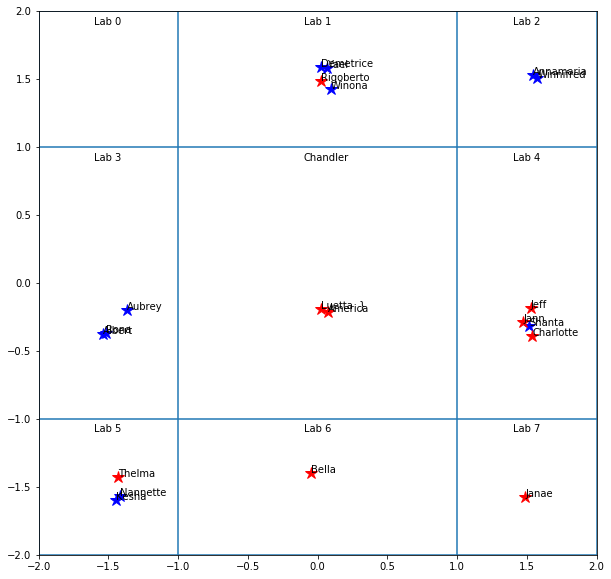

In [3]:
locations=['Lab 0','Lab 1','Lab 2','Lab 3','Lab 4','Lab 5','Lab 6','Lab 7','Chandler']
#input is an N-list containing the locations of each person
agent_locations = [np.random.choice(locations) for _ in range(npeople)]
disease_states = [np.random.choice([0,1]) for _ in range(npeople)]

fig,ax = plt.subplots(figsize=(10,10))



def draw_locations(agent_locations,disease_states,names,ax):
    """
    agent locations is a list containing the location of each agent in the simulation
    disease states is a list of booleans describing whether or not an individual is infected (0=healthy,1=infected)
    ax is the matplotlib axes object you want to draw on
    
    
    #USE A FIGSIZE OF 10,10
    
    returns nothing, operates in-place
    """
    #draw borders

    ax.set_ylim([-2,2])
    ax.set_xlim([-2,2])

    _=[ax.axhline(x,xmin=0,xmax=1) for x in [-2,-1,1,2]]
    _=[ax.axvline(x,ymin=0,ymax=1) for x in [-2,-1,1,2]]
    #add labels
    ax.text(1.4,-1.1,'Lab 7')
    ax.text(1.4,0.9,'Lab 4')
    ax.text(1.4,1.9,'Lab 2')
    ax.text(-.1,-1.1,'Lab 6')
    ax.text(-.1,0.9,'Chandler')
    ax.text(-.1,1.9,'Lab 1')
    ax.text(-1.6,-1.1,'Lab 5')
    ax.text(-1.6,0.9,'Lab 3')
    ax.text(-1.6,1.9,'Lab 0')

    center_coords = {'Lab 0':[-1.6,1.4],
                     'Lab 1':[-.1,1.4],
                     'Lab 2':[1.4,1.4],
                     'Lab 3':[-1.6,-0.4],
                     'Lab 4':[1.4,-0.4],
                     'Lab 5':[-1.6,-1.6],
                     'Lab 6':[-.1,-1.6],
                     'Lab 7':[1.4,-1.6],
                     'Chandler':[-.1,-0.4]}

    #iterate over people and draw each on the axis
    for person_idx in range(len(agent_locations)):
        deltax = st.uniform.rvs(scale=.25)
        deltay = st.uniform.rvs(scale=.25) #jittering points
        center = center_coords[agent_locations[person_idx]]

        if disease_states[person_idx]==0:
            color='blue'
        else:
            color='red'

        ax.plot(center[0]+deltax,center[1]+deltay,color=color,marker='*',markersize=12)
        ax.text(center[0]+deltax,center[1]+deltay,names[person_idx])

We're going to model movement via Markov chains. We're going to assume that...

1. Every person spends most of their time in a single lab (but allowed to travel elsewhere transiently)
2. Every person eats their lunch at Chandler, and eats exactly 1 lunch a day
3. Once at a location, people tend to stay there for a while (people don't rapidly jump from location to location)

We define a transition matrix for each person, i,  over $\mathbb{R}^{8x8}$. This matrix remains constant for each person

In [4]:
#time starts at 9 o clock; moving in 5 minute increments. an 8 hour day yields 96 increments
homeloc=3
totallocs=8
def loc_tmat(homeloc,totallocs):
    """
    generates a right stochastic matrix (transition matrix)
    homeloc is the location the person "hovers" at and returns to. totallocs is the number of locations open to the agents
    returns a matrix totallocs x totallocs
    """

    #adding 1 to diagonals off the bat to bias staying at a location
    returnmat = np.eye(totallocs)*100

    #adding a small amount to represent transitions between locations. We're sampling from a half normal.
    returnmat+= np.reshape(np.abs(st.norm.rvs(size=[totallocs*totallocs],scale=0.1)),[totallocs,totallocs])

    returnmat[:,homeloc]+= 25 #biasing movement towards home location
    returnmat[homeloc,homeloc]+= 25 #making sure we stay in home location if we get there
    returnmat = returnmat / returnmat.sum(axis=1)[:,None]  #normalization

    return returnmat

lunch_start = 36
mean_time=12
def get_lunchtimes(lunch_start=36,mean_time=12):
    """
    lunch_start is a scalar that describes the number of 5-minute intervals from 9 o clock that people will begin their lunch break (in 5-minute interval units; typically 36)
    mean_time is the average length of a lunchbreak, held to be 12 5-minute intervals or 60 minutes. units are 5-minute intervals
    returns a 2-list. the first list contains the lunch start times (in 5-minute interval units) and the second list contains the end times
    """
    start_times = [lunch_start + st.poisson.rvs(mu=10,size=npeople)]  #noising our start times with a poisson
    duration = [st.poisson.rvs(mu=mean_time,size=npeople)]
    end_times = [x+y for x,y in zip(start_times,duration)]
    return [start_times,end_times]

#state will be an 8 x N matrix
def gen_initstate(statefreqs=[0.4,0.3,0.2]+8*[0.1/8],N=10):
    """
    statefreqs is an 11-list describing the fraction of N occupying a particular state (healthy asymptomatic, healthy symptomatic, etc...)
    N is the total number of people
    returns an 11xN sparse matrix describing the state of each individual (by columns)
    """
    returnmat=[] #we're going to stack by columns, then shuffle
    for people_idx in range(N):
        append_mat = np.zeros(shape=11)
        append_mat[np.random.choice(np.arange(11),p=statefreqs)]=1
        returnmat.append(append_mat)
    random.shuffle(returnmat)
    return np.hstack([np.expand_dims(x,axis=-1) for x in returnmat])


We're modeling state transitions via Markov Chains. A partially filled-in transition matrix is below

![State Transition Chain](chain.png)

|     | SA | SS | SSS | EA  | ES  | ESS | IA | IS | ISS | R | D |
|-----|----|----|-----|-----|-----|-----|----|----|-----|---|---|
| SA  |    |    | 0   | PSE | 0   | 0   | 0  | 0  | 0   | 0 | 0 |
| SS  |    |    |     | 0   | PSE | 0   | 0  | 0  | 0   | 0 | 0 |
| SSS | 0  |    |     | 0   | 0   | PSE | 0  | 0  | 0   | 0 | 0 |
| EA  | 0  | 0  | 0   |     | 0   | 0   |    |    |     | 0 | 0 |
| ES  | 0  | 0  | 0   | 0   |     | 0   | 0  |    |     | 0 | 0 |
| ESS | 0  | 0  | 0   | 0   | 0   |     | 0  | 0  |     | 0 | 0 |
| IA  | 0  | 0  | 0   | 0   | 0   | 0   |    |    |     |   | 0 |
| IS  | 0  | 0  | 0   | 0   | 0   | 0   | 0  |    |     |   | 0 |
| ISS | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  |     |   |   |
| R   | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  | 0   | 1 | 0 |
| D   | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  | 0   | 0 | 1 |


The curly arrows on every node are implicit. None of the diagonals should be 0.


We need to define a few more probabilities to fill in the matrix. 

We assume that time from exposure to becoming infectious is around 5 days. This parameter will be called ndays_ei (STILL NEED TO IMPLEMENT, RIGHT NOW IT'S HARDCODED TO 5)

We also assume that the total timecourse of infection from exposure to recovery (or death) is ~ 14 days. This parameter will be called ndays_i (SAME AS ABOVE)

We assume around 10% of the (non-exposed) population will develop symptoms similar to CoViD over the course of a year (flu), with 1% generating severe symptoms. We'll need to calculate these transitions based on the length of the simulation.

We'll also assume around 5% of people who develop severe CoViD symptoms will die of the disease. We'll assume that 1% of patients develop severe covid symptoms (~10x higher than it actually is, necessary for such a small simulation.https://www.cdc.gov/coronavirus/2019-ncov/covid-data/covidview/index.html, asssuming hospitalization=strong symptoms)

I'm assuming around 50% of exposed/infected people are asymptomatic https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/.


|     | SA | SS | SSS | EA  | ES  | ESS | IA | IS | ISS | R | D |
|-----|----|----|-----|-----|-----|-----|----|----|-----|---|---|
| SA  | 0.9(1-PSE)   | 0.1(1-PSE)   | 0   | PSE | 0   | 0   | 0  | 0  | 0   | 0 | 0 |
| SS  | 0.1(1-PSE)   | 0.89(1-PSE)   | 0.01(1-PSE)    | 0   | PSE | 0   | 0  | 0  | 0   | 0 | 0 |
| SSS | 0  |  0.1(1-PSE)  |  0.9(1-PSE)   | 0   | 0   | PSE | 0  | 0  | 0   | 0 | 0 |
| EA  | 0  | 0  | 0   |  1-(1/1440)   | 0   | 0   |  0.94(1/1440)  | 0.05 (1/1440)  |  0.01(1/1440)   | 0 | 0 |
| ES  | 0  | 0  | 0   | 0   |  1-(1/1440)   | 0   | 0  | 0.9(1/1440)   |  0.1(1/1440)   | 0 | 0 |
| ESS | 0  | 0  | 0   | 0   | 0   |  1-(1/1440)   | 0  | 0  |  1/1440   | 0 | 0 |
| IA  | 0  | 0  | 0   | 0   | 0   | 0   | 0.9(1-(1/2592))   |  0.1((1-1/2592))  |   0  | 1/(2592)  | 0 |
| IS  | 0  | 0  | 0   | 0   | 0   | 0   | 0  |  0.9(1-1/2592)  | 0.1(1-1/2592)    | 1/(2592)  | 0 |
| ISS | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  |  1-1/2592   | 0.95(1/2592)  | 0.05(1/2592)  |
| R   | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  | 0   | 1 | 0 |
| D   | 0  | 0  | 0   | 0   | 0   | 0   | 0  | 0  | 0   | 0 | 1 |

I'm pulling these values mostly from thin air (just doing 1/nintervals; not all values follow logic laid out above...). I need to justify these better. Good enough to prototype though.

In [5]:
def state_tmat(pse=0.0000001):
    """
    pse is a float describing the probability someone in a non-infected state will transition to an infected state (per time interval)
    returns an 11x11 transition matrix
    
    default pse value reflects community rate of infection (FIX ME!!!!!!!!)
    """
    outarray = np.eye(11) #takes care of the last two rows from the get-go
    outarray[0,:]=[0.9*(1-pse),0.1*(1-pse),0,pse,0,0,0,0,0,0,0]
    outarray[1,:] = [0.1*(1-pse),0.89*(1-pse),0.01*(1-pse),0,pse,0,0,0,0,0,0]
    outarray[2,:] = [0,0.1*(1-pse),0.9*(1-pse),0,0,pse,0,0,0,0,0]
    outarray[3,:] = [0,0,0,1-(1/1440),0,0,0.94*(1/1440),0.05*(1/1440),0.01*(1/1440),0,0]
    outarray[4,:] = [0,0,0,0,1-(1/1440),0,0,0.9*(1/1440),0.1*(1/1440),0,0]
    outarray[5,:] = [0,0,0,0,0,1-(1/1440),0,0,1/1440,0,0]
    outarray[6,:] = [0,0,0,0,0,0,0.9*(1-1/2592),0.1*(1-1/2592),0,1/2592,0]
    outarray[7,:] = [0,0,0,0,0,0,0,0.9*(1-1/2592),0.1*(1-1/2592),1/2592,0]
    outarray[8,:] = [0,0,0,0,0,0,0,0,1-1/2592,0.95*(1/2592),0.05*(1/2592)]
    return outarray

### Main Simulation

In [6]:
ndays=2

agent_locations = np.empty(shape=[96*ndays,npeople],dtype=object)
agent_states = np.zeros(shape=[96*ndays,11,npeople])

loc_weights = st.uniform.rvs(size=len(locations))

#instantiate location and state and transition matrices
agent_locations[0,:] = np.random.choice(locations[:-1],size=npeople)
agent_states[0,...] = gen_initstate(N=npeople)

if np.sum(agent_states[0,...])==0:
    agent_states[0,-1,-1] = 1 #make the last person (very) sick if no one else is

agent_loctmats = [loc_tmat(np.random.choice(np.arange(len(locations)-1)),len(locations)-1) for _ in range(npeople)] #instantiate transition matrices for movement

prev_idx=0

#main simulation loop
for day_idx in range(ndays):  #loop over days
    lunchtimes = get_lunchtimes()
    current_time=0

    agent_locations[day_idx*96,:] = np.random.choice(locations[:-1],size=npeople)
    if day_idx!=0:
        agent_states[day_idx*96,:] = agent_states[prev_idx,:] #carrying over the state isn't valid if it's day 0
    
    

    for time_idx in range(1,96): #loop over small time interval (now 5 minutes.)
        #so I don't have to calculate this value a ton of times
        current_idx = day_idx*96+time_idx
        #print('current_idx: ',current_idx,end='\r')
        
        

        for person_idx in range(npeople):
            
            
            
            #############################################
            # Movement Subroutine (Put me in a function!)
            #############################################
            #first we check lunchtime conditions,check if any lunchtimes have started or if we're in the middle of a lunch period
            if lunchtimes[1][0][person_idx]>=current_time and current_time>= lunchtimes[0][0][person_idx]:
                #print('trigered: ',time_idx,end='\r')
                agent_locations[current_idx,person_idx] = 'Chandler' #force that person to go to Chandler within their planned lunch period
              
            else:
                #call transition matrix
                tmat = agent_loctmats[person_idx]
                prev_location = locations.index(agent_locations[prev_idx,person_idx])
         
                if prev_location == 8:
                    prev_location = np.random.choice(np.arange(len(locations[:-1])))  #in case the last location is chandler, feed in a random location so things don't break
                #vectorize the location
                prev_vec = np.zeros([1,len(locations[:-1])])
                prev_vec[0,prev_location] = 1
                
                current_location = np.random.choice(locations[:-1],p=np.squeeze(np.matmul(prev_vec,tmat)))
                agent_locations[current_idx,person_idx] = current_location
            #################################################
            # End Movement
            #################################################
        
            #################################################
            # Transmission Subroutine (Put me in a function!)
            #################################################
            #we need to calculate the pse for the current person. defining lambda here because the stuff below is going to eventually be functionalized.
            lambda_ = 1e18 #underscore is necessary because lambda functions exist; set to ~1e20 to get everyone infected on the first day
            
            #get indices of people at agent location
            loc_indices = np.where(agent_locations[current_idx,:]==current_location)[0]
     
            infect_list = [np.sum(agent_states[current_idx,3:9,x]) for x in loc_indices]
            ninfected = np.sum(infect_list)
       
            pse = 1. - np.exp(-lambda_*loc_weights[locations.index(current_location)]*ninfected)
       
            if np.isnan(pse) or np.isinf(pse):  #cleaning up errors
                pse=0
            
            #create transition matrix
            tmat = state_tmat(pse)
            prev_state = np.where(agent_states[prev_idx,:,person_idx]==1)[0] 
    
            #print(np.squeeze(tmat[prev_state,:]))
            if len(prev_state)!=1:
                 print('current_idx: ',current_idx,' prev_state; ',prev_state)
            next_state = np.random.choice(np.arange(11),p=np.squeeze(tmat[prev_state,:]))
            agent_states[current_idx,next_state,person_idx] = 1
  
            ###################################################
            # End Transmission
            ###################################################
        prev_idx = current_idx
        
        
        
        current_time+=1
            

Visualization and animation code below.

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


GIF Finished!  192


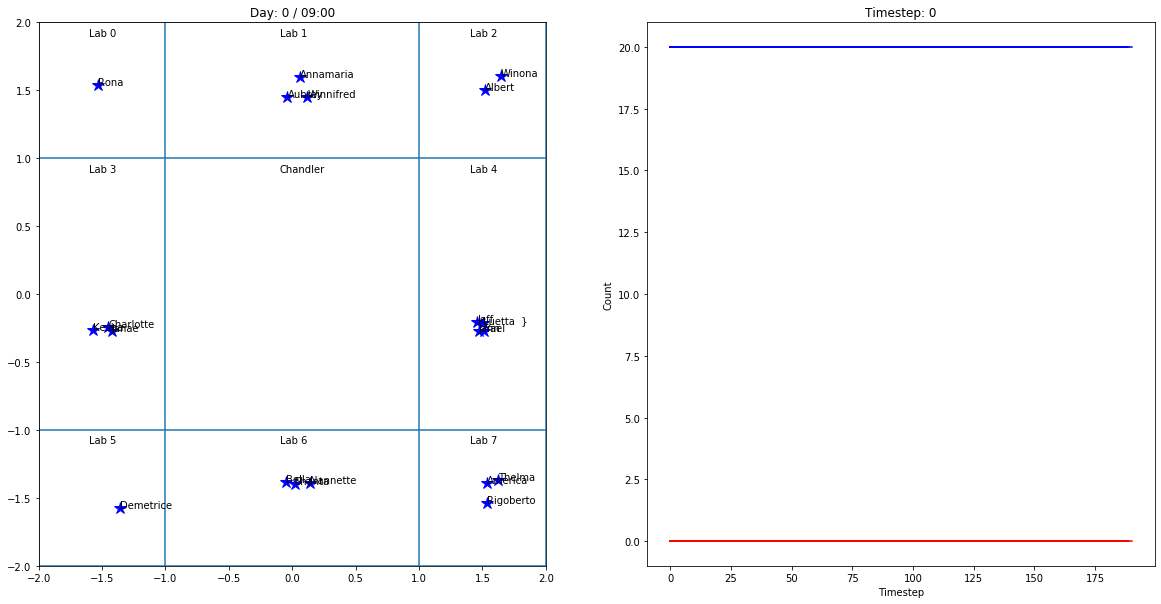

In [7]:
def num2titlestr(n):
    day = n//96
    day_rem = n % 96
    hours = day_rem // 12
    
    fmt_hours = 9 + hours
    if fmt_hours>12:
        fmt_hours+=-12
    fmt_hours= str(fmt_hours)
    if len(fmt_hours)!=2:
        fmt_hours = '0'+fmt_hours
    
    hour_rem = day_rem % 12
    minutes = hour_rem * 5
    fmt_minutes = str(minutes)
    if len(fmt_minutes) != 2:
        fmt_minutes = '0'+fmt_minutes
    return 'Day: '+str(day)+' / '+ fmt_hours+':'+fmt_minutes


fig,ax = plt.subplots(ncols=2,figsize=[20,10])

ni_counts=np.zeros(shape=agent_locations.shape[0])
i_counts=np.zeros(shape=agent_locations.shape[0])
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Count')
def update(i):
    print('Step: ',i,' / ',agent_locations.shape[0],end='\r')

    ax[0].clear()
    ax[0].set_title(num2titlestr(i))    
    disease_states = np.squeeze(agent_states[i,:,:])  #we need to "compress this one hot matrix (one hot along columns)"
    disease_states = np.array([np.where(disease_states[:,x]==1)[0] for x in range(disease_states.shape[1])])
    
    disease_states[disease_states==9]=0
    disease_states[disease_states<=2]=0
    disease_states[disease_states>2]=1
    #print(disease_states)
    draw_locations(agent_locations[i,:],disease_states,names,ax[0])
    
    i_counts[i]=np.count_nonzero(disease_states)
    ni_counts[i]=disease_states.size-np.count_nonzero(disease_states)
    ax[1].plot(ni_counts[:i],'-b')
    ax[1].plot(i_counts[:i],'-r')
    ax[1].set_title('Timestep: '+str(i))

anim = FuncAnimation(fig, update, frames=np.arange(0, agent_locations.shape[0]), interval=200,repeat_delay=1000)

anim.save('model_new.gif', dpi=80, writer='imagemagick')
print('GIF Finished!')

The blue dots represent all not-infected/recovered people and the red dots represent exposed/infected people.